In [117]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from pathlib import Path

In [118]:
# -- NEW ANALYZE FACES NOTEBOOK --
# 1. Detect valid frames (frames where we have searched faces)
#    Center frame the 80s is the frame where action t=0
# 2. Assign frames to an action
# 3. Create interesting dataframes as the following ones

In [308]:
# detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/europe_uefa-champions-league/2016-2017/2017-03-07 - 22-45 Napoli 1 - 3 Real Madrid/face_detection_results_1_HQ.npy')
detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/europe_uefa-champions-league/2016-2017/2017-03-08 - 22-45 Barcelona 6 - 1 Paris SG/face_detection_results_1_HQ.npy')
detections_path_2 = Path('../../../../mnt/DATA/datasets/soccernet/europe_uefa-champions-league/2016-2017/2017-03-08 - 22-45 Barcelona 6 - 1 Paris SG/face_detection_results_2_HQ.npy')
# detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_1_HQ.npy')
# detections_path_2 = Path('../../../../mnt/DATA/datasets/soccernet/england_epl/2014-2015/2015-02-21 - 18-00 Chelsea 1 - 1 Burnley/face_detection_results_2_HQ.npy')
# detections_path_1 = Path('../../../../mnt/DATA/datasets/soccernet/england_epl/2016-2017/2016-08-27 - 14-30 Tottenham 1 - 1 Liverpool/face_detection_results_1_HQ.npy')
# detections_path_2 = Path('../../../../mnt/DATA/datasets/soccernet/england_epl/2016-2017/2016-08-27 - 14-30 Tottenham 1 - 1 Liverpool/face_detection_results_2_HQ.npy')
detections1 = np.load(detections_path_1, allow_pickle=True)[0]
detections2 = np.load(detections_path_2, allow_pickle=True)[0]


In [309]:
count1=0
for frame_id in detections1.keys():
    if len(detections1[frame_id]) > 0:
        count1 += len(detections1[frame_id])
        
count2=0
for frame_id in detections2.keys():
    if len(detections2[frame_id]) > 0:
        count2 += len(detections2[frame_id])

In [310]:
count1 + count2

63867

In [311]:
from pathlib import Path
import json
import cv2

json_path = detections_path_1.parent.joinpath('Labels-v2.json')
with open(json_path) as f:
    data = json.load(f)
annotations = data['annotations']
for i in range(0, len(annotations)):
    if annotations[i]['gameTime'][0] == '2':
        index = i
        break
an1 = annotations[:index]
an2 = annotations[index:]
actions = [an1, an2]

In [312]:
count_corners = 0
for a in annotations:
    if a['label']=='Corner':
        count_corners += 1
        
count_corners

9

In [313]:
def first_last_frame(frame_num, seconds_window, fs):
    first = max(frame_num - (seconds_window * fs), 1)
    last = (frame_num + (seconds_window * fs))
    return first, last

def get_frame(position, fs):
    return (position // 1000) * fs

def get_valid_frames_df(half, detections_path):
    frames_dir = detections_path.parent.joinpath(f'{half+1}_HQ','frames')
    seconds_window = 10
    fs = 8
    num_frames = len(list(frames_dir.glob('*.jpg')))

    valid_frames = set()
    for action in actions[half]:
        position = int(action['position'])
        frame_num = get_frame(position, fs)
        first_action_frame, last_action_frame = first_last_frame(frame_num, seconds_window, fs)
        for frame_id in range(first_action_frame, last_action_frame+1):
            valid_frames.add((f'{frame_id:05}', action['label'], first_action_frame, last_action_frame, int((first_action_frame+last_action_frame)/2)))

    invalid_frames = list(set(np.arange(num_frames)) - valid_frames)
    valid_frames = sorted(valid_frames)
    valid_frames_df = pd.DataFrame(valid_frames, columns=['frame','label','first','last','center'])
    
    return (valid_frames_df, valid_frames)
    
def get_faces_list_df(vf, detections):
    faces_list_df = pd.DataFrame(columns=['frame','face_id','info'])
    count = 0
    for key in vf:
        if len(detections[key[0]])>0:
            for face in detections[key[0]]:
                count += 1
                line = pd.DataFrame({'frame':[key[0]], 'face_id':[face], 'info':[detections[key[0]][face]['score']]})
                faces_list_df = pd.concat([faces_list_df, line], axis=0)
    # print(count)
    return faces_list_df

In [314]:
valid_frames_df_1, valid_frames_1 = get_valid_frames_df(0, detections_path_1)
valid_frames_df_2, valid_frames_2 = get_valid_frames_df(1, detections_path_2)


In [315]:
keys1 = valid_frames_df_1['frame'].to_list()
only_faces_dict1 = dict([(key, len(detections1[key])) for key in keys1 if key in detections1.keys()])

keys2 = valid_frames_df_2['frame'].to_list()
only_faces_dict2 = dict([(key, len(detections2[key])) for key in keys2 if key in detections2.keys()])

num_faces_column1 = pd.DataFrame.from_dict(only_faces_dict1, orient='index').rename(columns={0:'num_faces'})
num_faces_df1 = pd.merge(valid_frames_df_1, num_faces_column1, left_on='frame', right_index=True)
num_faces_df1['half'] = 1

num_faces_column2 = pd.DataFrame.from_dict(only_faces_dict2, orient='index').rename(columns={0:'num_faces'})
num_faces_df2 = pd.merge(valid_frames_df_2, num_faces_column2, left_on='frame', right_index=True)
num_faces_df2['half'] = 2

num_faces_df = pd.concat([num_faces_df1, num_faces_df2]).reset_index(drop=True)


In [316]:
num_actions = num_faces_df[['label','center']].drop_duplicates()
num_actions['action_appearances'] = 1
num_actions = num_actions[['label','action_appearances']].groupby(['label'], as_index=False).sum()

faces_per_action = num_faces_df[['label','num_faces']].groupby(['label'], as_index=False).sum()

faces_per_appearence = pd.merge(faces_per_action, num_actions, on=['label'])
faces_per_appearence['faces_per_appearance'] = faces_per_action['num_faces'] / num_actions['action_appearances']
faces_per_appearence.head()

,label,num_faces,action_appearances,faces_per_appearance
0,Ball out of play,20634,68,303.441176
1,Clearance,19720,20,986.000000
2,Corner,2018,9,224.222222
3,Direct free-kick,3509,6,584.833333
4,Foul,3470,41,84.634146


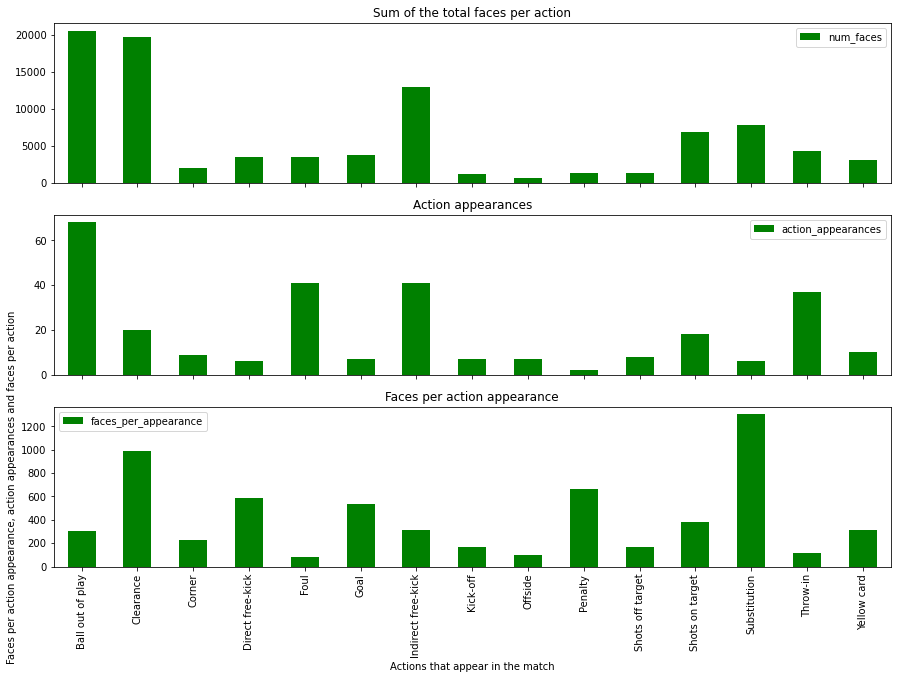

In [317]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True)

faces_per_appearence.plot(kind='bar',x='label',y='num_faces',color='green', figsize=(15,15),
       title='Sum of the total faces per action', ax=axes[0])
faces_per_appearence.plot(kind='bar',x='label',y='action_appearances',color='green', figsize=(15,15),
       title='Action appearances', ax=axes[1])
faces_per_appearence.plot(kind='bar',x='label',y='faces_per_appearance',color='green', figsize=(15,10),
       title='Faces per action appearance',ax=axes[2])

plt.xlabel('Actions that appear in the match')
plt.ylabel('Faces per action appearance, action appearances and faces per action')
plt.show()


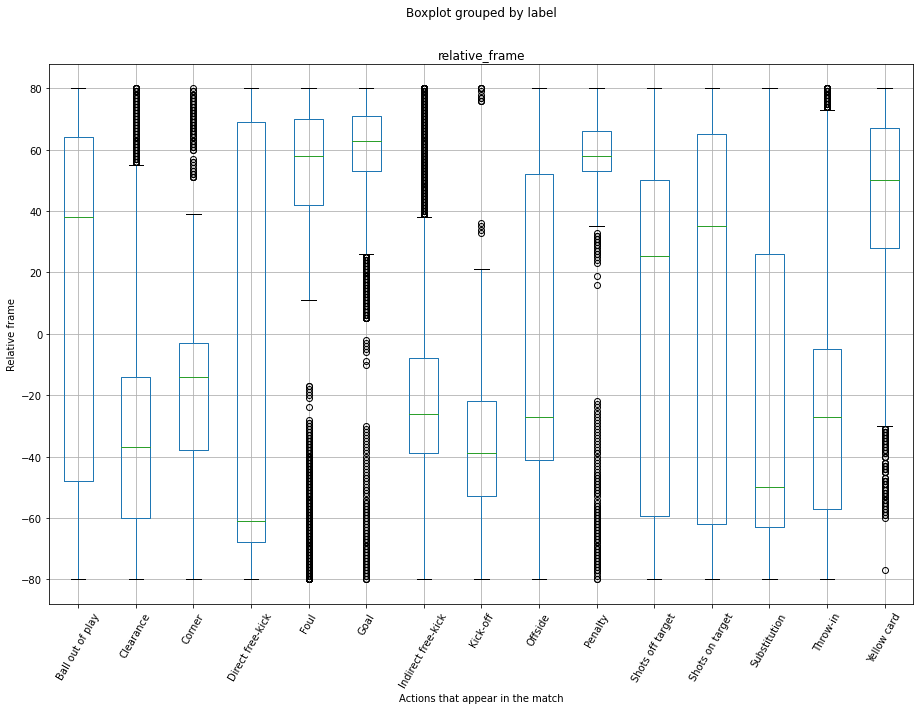

In [318]:
diff = num_faces_df.loc[num_faces_df['num_faces']>0].copy()
diff['relative_frame'] = diff['frame'].astype(int) - diff['center']
diff = diff.loc[diff.index.repeat(diff.num_faces)]
diff.boxplot(column='relative_frame',by='label', figsize=(15,10), rot='60')
plt.xlabel('Actions that appear in the match')
plt.ylabel('Relative frame')
plt.show()
